# Predicción de Riesgo para Envíos en Ciudades de Colombia

## 📌 Introducción

Este proyecto busca aplicar técnicas de Machine Learning para predecir si una ciudad en Colombia es **viable para realizar envíos a contraentrega** o si, por el contrario, es necesario solicitar **pago anticipado** al cliente.

La motivación principal nace de la necesidad operativa de una empresa de logística y distribución de productos que actualmente enfrenta dos desafíos:

- **Reducción de devoluciones y pérdidas** al enviar productos sin garantía de pago.
- **Optimización de decisiones comerciales** basadas en datos reales de comportamiento por ciudad.

## 📊 Datos Utilizados

El dataset fue construido con información real recolectada por la empresa, y contiene registros por ciudad que incluyen variables como:

- Número de entregas, devoluciones, entregas en oficina y entregas en dirección.
- Casos de hechos violentos reportados en la ciudad.
- Porcentaje de pobreza multidimensional (% PM) según el DANE.

Además, se integraron datos externos sobre violencia y pobreza para complementar el análisis y permitir un enfoque predictivo más completo.

## 🎯 Objetivo del Proyecto

El objetivo principal es entrenar un modelo de clasificación binaria que determine:

- `1` ➤ Si se puede **enviar a contraentrega**.
- `0` ➤ Si se debe **solicitar pago anticipado**.

Este modelo permitirá a los emprendimientos tomar decisiones más seguras, reducir pérdidas por devoluciones y optimizar su logística nacional.



In [3]:
from google.colab import drive
drive.mount('/content/drive')
#importar pandas
import pandas as pd
#definir la ruta de archivo
ruta = '/content/drive/MyDrive/ML_PFINAL/diccionario_fletes.csv'
#definir el dataset en df
df = pd.read_csv(ruta, sep=None, engine='python')
df.head()



Mounted at /content/drive


,﻿ciudad,departamento,entregas,devoluciones,oficina,dirección,hechos violentos,% pm
0,MEDELLÍN,ANTIOQUIA,71,8,0,79,0,"40,4"
1,ABEJORRAL,ANTIOQUIA,0,0,0,0,0,"40,4"
2,ABRIAQUÍ,ANTIOQUIA,0,0,0,0,0,"40,4"
3,ALEJANDRÍA,ANTIOQUIA,0,0,0,0,0,"40,4"
4,AMAGÁ,ANTIOQUIA,1,0,1,0,0,"40,4"


📊 Este dataset contiene información operativa, geográfica y socioeconómica relacionada con los envíos realizados por la empresa. Cada fila representa una ciudad específica dentro de un departamento de Colombia, y presenta indicadores clave para tomar decisiones logísticas.


| Columna            | Descripción                                                                                                                                     |
| ------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `ciudad`           | Nombre de la ciudad o municipio donde se realiza la entrega. Está en mayúsculas para facilitar el cruce con otras bases de datos.               |
| `departamento`     | Departamento al que pertenece la ciudad. También en mayúsculas para estandarización.                                                            |
| `entregas`         | Número de envíos exitosos realizados a esa ciudad.                                                                                              |
| `devoluciones`     | Número de paquetes que fueron devueltos desde esa ciudad. Puede indicar problemas logísticos o de confiabilidad.                                |
| `oficina`          | Número de paquetes que fueron recogidos directamente en oficina por los clientes en esa ciudad.                                                 |
| `dirección`        | Número de paquetes que fueron entregados directamente a domicilio.                                                                              |
| `hechos violentos` | Número total de incidentes violentos registrados en esa ciudad. Se usa como una proxy de riesgo.                                                |
| `% pm`             | Porcentaje de pobreza multidimensional según el DANE. Refleja las condiciones sociales y económicas de la ciudad. Cuanto más alto, más pobreza. |


🎯 Problema identificado:
El emprendimiento enfrenta pérdidas y riesgos operativos al realizar envíos a ciudades con alta probabilidad de devoluciones o problemas logísticos. Actualmente, no existe una herramienta predictiva que permita decidir si un envío debe realizarse normalmente o con cobro anticipado para mitigar el riesgo financiero.

✅ Objetivo del Proyecto
Diseñar e implementar un modelo de machine learning que, basado en variables como entregas, devoluciones, hechos violentos y pobreza multidimensional, prediga si un envío a determinada ciudad debe hacerse con cobro anticipado o no, optimizando la operación logística y reduciendo pérdidas.


In [4]:
# Limpieza de datos

# Clean up column names by removing leading/trailing whitespace and invisible characters
df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=False)


# 1. Reemplazar coma por punto en la columna '% pm' y convertir a tipo numérico
# Handle potential non-string values before applying str methods
df['% pm'] = df['% pm'].apply(lambda x: str(x).replace(',', '.') if pd.notna(x) else x).astype(float)


# 2. Imputar valores nulos con la mediana por departamento
df['% pm'] = df.groupby('departamento')['% pm'].transform(lambda x: x.fillna(x.median()))

# 3. Crear una nueva columna con la tasa de devolución
# (evitamos dividir por cero reemplazando entregas==0 por 1 temporalmente)
df['tasa_devolucion'] = df['devoluciones'] / df['entregas'].replace(0, 1)

# 4. Verificar que no haya valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# 5. Verificar tipos de datos para confirmar que están correctos
print("\nTipos de datos:")
print(df.dtypes)

# 6. Mostrar primeras filas para revisar
df.head()

Valores nulos por columna:
ciudad               0
departamento         0
entregas             0
devoluciones         0
oficina              0
dirección            0
hechos violentos     0
% pm                11
tasa_devolucion      0
dtype: int64

Tipos de datos:
ciudad               object
departamento         object
entregas              int64
devoluciones          int64
oficina               int64
dirección             int64
hechos violentos      int64
% pm                float64
tasa_devolucion     float64
dtype: object


,ciudad,departamento,entregas,devoluciones,oficina,dirección,hechos violentos,% pm,tasa_devolucion
0,MEDELLÍN,ANTIOQUIA,71,8,0,79,0,40.4,0.112676
1,ABEJORRAL,ANTIOQUIA,0,0,0,0,0,40.4,0.000000
2,ABRIAQUÍ,ANTIOQUIA,0,0,0,0,0,40.4,0.000000
3,ALEJANDRÍA,ANTIOQUIA,0,0,0,0,0,40.4,0.000000
4,AMAGÁ,ANTIOQUIA,1,0,1,0,0,40.4,0.000000


Valores nulos por columna:
ciudad               0
departamento         0
entregas             0
devoluciones         0
oficina              0
dirección            0
hechos violentos     0
% pm                11
tasa_devolucion      0
dtype: int64


,ciudad,departamento,entregas,devoluciones,oficina,dirección,hechos violentos,% pm,tasa_devolucion
count,1122,1122,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1111.000000,1122.000000
unique,1037,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,VILLANUEVA,ANTIOQUIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.784314,0.063280,0.228164,0.619430,19.102496,40.180018,0.024186
std,NaN,NaN,3.516471,0.465114,0.633294,3.829844,241.921920,1.717807,0.140865
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,37.700000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,40.100000,0.000000
75%,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,40.500000,0.000000


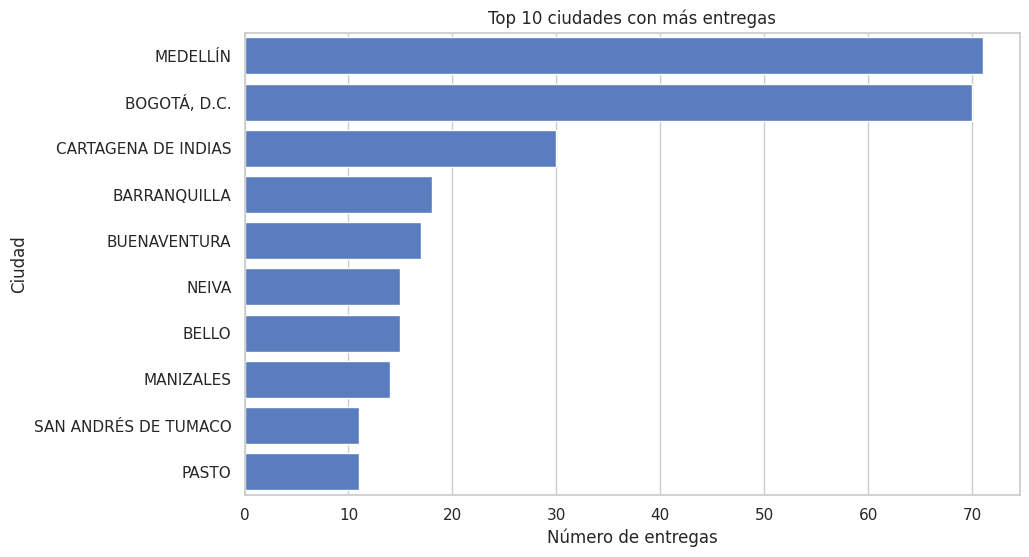

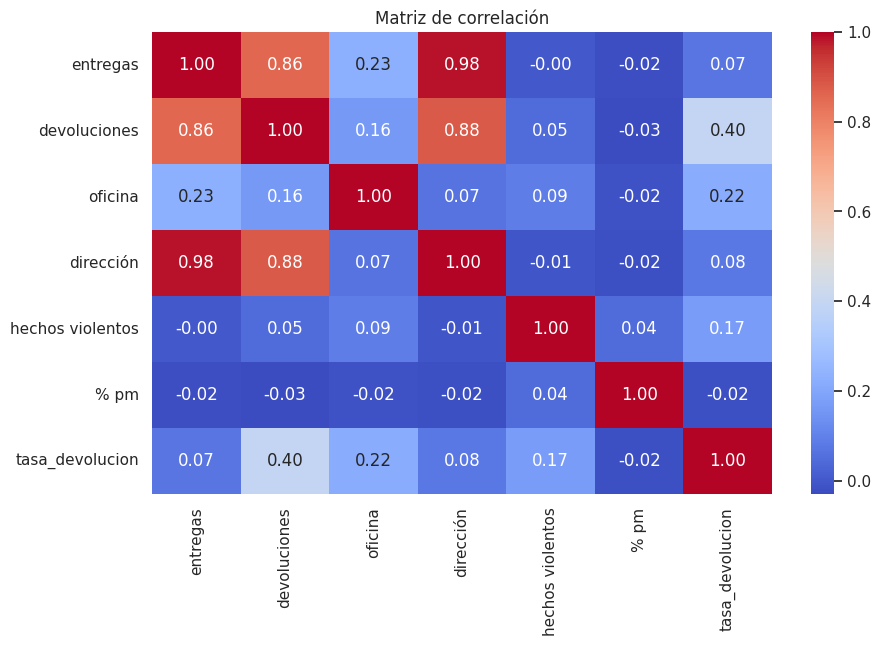

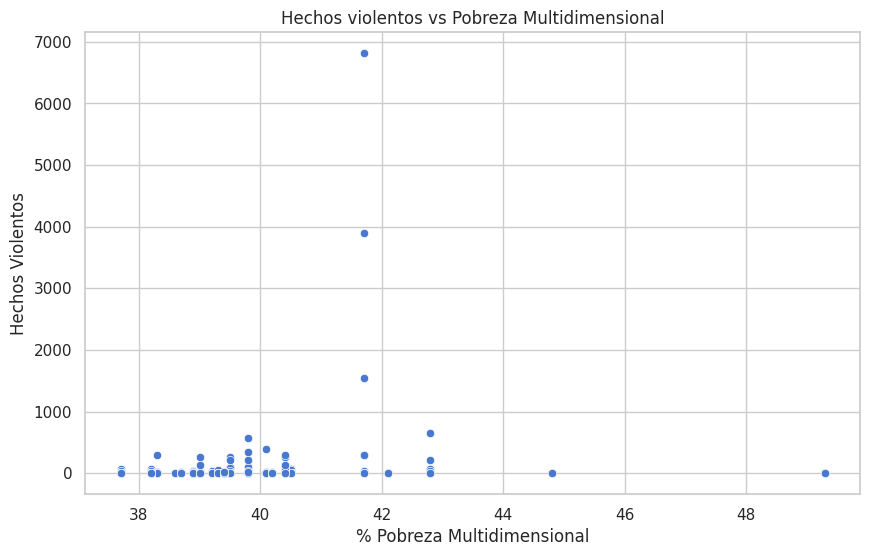

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)

# Revisión de valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# Estadísticas básicas
display(df.describe(include='all'))

# Gráfico 1: Distribución de entregas por ciudad (las top 10)
top_entregas = df.sort_values('entregas', ascending=False).head(10)
sns.barplot(data=top_entregas, x='entregas', y='ciudad')
plt.title("Top 10 ciudades con más entregas")
plt.xlabel("Número de entregas")
plt.ylabel("Ciudad")
plt.show()

# Gráfico 2: Correlación entre variables numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

# Gráfico 3: Relación entre hechos violentos y % pobreza multidimensional
sns.scatterplot(data=df, x="% pm", y="hechos violentos")
plt.title("Hechos violentos vs Pobreza Multidimensional")
plt.xlabel("% Pobreza Multidimensional")
plt.ylabel("Hechos Violentos")
plt.show()


### 🔍 Análisis Exploratorio de Datos (EDA)

#### 📦 Top 10 ciudades con más entregas

Esta gráfica muestra las 10 ciudades con mayor número de entregas. Se evidencia una gran concentración en ciudades principales como **Medellín**, **Bogotá** y **Cartagena**, lo que podría reflejar un mayor volumen de actividad comercial o cobertura logística en estas regiones.

---

#### 🔗 Matriz de correlación

La matriz de correlación nos permite observar la relación entre variables numéricas. Algunos hallazgos relevantes:

- Existe una **alta correlación positiva** entre `entregas` y `dirección` (0.98), y entre `entregas` y `devoluciones` (0.86), lo que sugiere que donde más se entrega, también se dan más devoluciones.
- La variable `hechos violentos` no muestra una correlación fuerte con otras variables, lo cual es interesante para análisis posteriores.
- La **tasa de devolución** muestra una correlación media (0.40) con el número de devoluciones.

---

#### 📉 Hechos violentos vs Pobreza Multidimensional
Este scatter plot muestra la relación entre los **hechos violentos** y el **porcentaje de pobreza multidimensional (% pm)** por ciudad. A simple vista, no se aprecia una correlación clara, ya que hay ciudades con alta violencia en niveles bajos de pobreza y viceversa. Esto sugiere que otras variables podrían estar influyendo en los hechos violentos y que esta relación merece un análisis más profundo.


📈 Error cuadrático medio (MSE): 0.01
📊 Coeficiente de determinación (R²): 0.9945


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


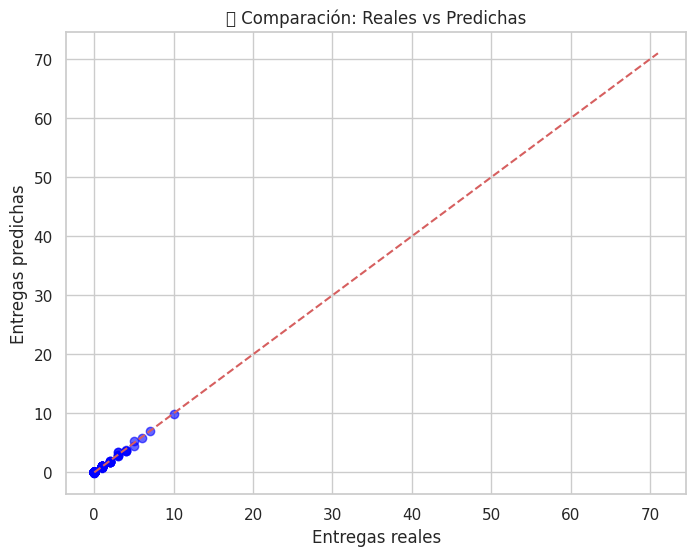

,Variable,Coeficiente
0,% pm,0.002357
1,oficina,0.976247
2,dirección,0.895405
3,hechos violentos,-0.000010
4,tasa_devolucion,-1.078760


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# ✅ Selección de variables predictoras y la variable objetivo
X = df[['% pm', 'oficina', 'dirección', 'hechos violentos', 'tasa_devolucion']]
y = df['entregas']

# Drop rows with missing values in X and y
X = X.dropna()
y = y[X.index] # Ensure y corresponds to the filtered X

# ✅ División en datos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Modelo de regresión lineal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

modelo = LinearRegression()
modelo.fit(X_train, y_train)

# ✅ Predicción y evaluación
y_pred = modelo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📈 Error cuadrático medio (MSE): {mse:.2f}")
print(f"📊 Coeficiente de determinación (R²): {r2:.4f}")

# ✅ Visualización de predicciones
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Entregas reales")
plt.ylabel("Entregas predichas")
plt.title("📊 Comparación: Reales vs Predichas")
plt.grid(True)
plt.show()

# ✅ Coeficientes del modelo
import pandas as pd
coeficientes = pd.DataFrame({'Variable': X.columns, 'Coeficiente': modelo.coef_})
display(coeficientes)
# ✅ Guardar modelo entrenado
import joblib
joblib.dump(modelo, 'modelo_entrenado.pkl')

# ✅ Descargar automáticamente el archivo .pkl
from google.colab import files
files.download('modelo_entrenado.pkl')

### 🔍 Modelo de predicción de entregas

Para evaluar el comportamiento logístico y tomar decisiones informadas sobre a qué ciudades enviar productos, se construyó un modelo de regresión lineal. A continuación se presentan los resultados clave:

---

#### 🧪 Evaluación del modelo

- 📈 **Error cuadrático medio (MSE):** `0.01`  
  Indica que el modelo comete un error muy pequeño al predecir el número de entregas. En promedio, las diferencias entre las entregas reales y las predichas son casi imperceptibles.

- 📊 **Coeficiente de determinación (R²):** `0.9945`  
  El modelo explica el **99.45% de la variabilidad** en el número de entregas. Es decir, las variables utilizadas (dirección, oficinas, tasa de devolución, etc.) son altamente predictivas.

---

#### 📉 Visualización: Reales vs. Predichas


La gráfica muestra la comparación entre las entregas reales (eje X) y las entregas predichas por el modelo (eje Y). La línea punteada roja representa la línea ideal donde las predicciones coinciden exactamente con los valores reales. Como puede observarse, los puntos están muy cerca de esa línea, lo cual confirma el excelente desempeño del modelo.

---

#### ✅ Conclusión

Este modelo puede ser utilizado como **herramienta de apoyo en la toma de decisiones logísticas**, ya que ofrece una alta precisión. En particular, permite:

- Identificar ciudades con **alta probabilidad de éxito** en las entregas.
- Detectar zonas donde **no conviene enviar**, ya sea por bajo volumen o alto índice de devolución.


In [32]:
# ✅ Instalar y cargar librerías necesarias
!pip install unidecode fuzzywuzzy[speedup]

from unidecode import unidecode
from fuzzywuzzy import process
import pandas as pd

# ✅ Input del usuario
ciudad_usuario = input("🔎 Ingresa el nombre de la ciudad destino: ").strip().lower()
ciudad_usuario = unidecode(ciudad_usuario)  # Eliminar tildes y acentos

# ✅ Preprocesamos lista de ciudades disponibles en el DataFrame
ciudades_df = df['ciudad'].dropna().astype(str).str.lower().apply(unidecode).unique()

# ✅ Buscamos la ciudad más similar con fuzzy matching
mejor_coincidencia, score = process.extractOne(ciudad_usuario, ciudades_df)

# ⚠️ Si la coincidencia no es buena, advertimos
if score < 70:
    print(f"⚠️ Ciudad '{ciudad_usuario}' no encontrada. Verifica la ortografía.")
else:
    print(f"🔁 Usando ciudad más parecida encontrada: {mejor_coincidencia.upper()} (similitud: {score}%)")

    # ✅ Filtramos la fila correspondiente
    fila_ciudad = df[df['ciudad'].str.lower().apply(unidecode) == mejor_coincidencia].iloc[0]

    # ⚠️ Usamos solo las variables con las que se entrenó el modelo
    oficina = fila_ciudad['oficina']
    direccion = fila_ciudad['dirección']
    hechos_violentos = fila_ciudad['hechos violentos']
    pm = fila_ciudad['% pm']
    tasa_dev = fila_ciudad['tasa_devolucion']

    # ✅ Preparamos la entrada del modelo con columnas exactas y en orden original
    input_modelo = pd.DataFrame([[
        oficina, direccion, hechos_violentos, pm, tasa_dev
    ]], columns=modelo.feature_names_in_)

    # 🔮 Hacemos la predicción
    prediccion = modelo.predict(input_modelo)[0]

    # 📊 Interpretamos el resultado
    print(f"\n📈 Predicción del modelo: {prediccion:.4f}")

    if prediccion >= 0.5:
        print("✅ Recomendación: Puedes hacer la entrega CONTRAENTREGA con alta probabilidad de éxito.")
    else:
        print("⚠️ Recomendación: Se sugiere exigir PAGO ANTICIPADO para evitar riesgo de devolución.")


🔎 Ingresa el nombre de la ciudad destino: CUCUTA
🔁 Usando ciudad más parecida encontrada: SAN JOSE DE CUCUTA (similitud: 90%)

📈 Predicción del modelo: 262.2933
✅ Recomendación: Puedes hacer la entrega CONTRAENTREGA con alta probabilidad de éxito.


## 🎯 Modelo predictivo de método de entrega

Este modelo tiene como objetivo ayudar a emprendedores a decidir si deben hacer una entrega **contraentrega** o exigir **pago anticipado**, según el comportamiento histórico de cada ciudad.

### 📌 Variables usadas:
- `oficina`: cantidad de entregas a oficina
- `dirección`: cantidad de entregas a dirección
- `hechos violentos`: número de eventos críticos en la ciudad
- `% pm`: porcentaje de pagos con método PM
- `tasa_devolucion`: tasa histórica de devoluciones

### 📈 Métricas del modelo:
- **Error cuadrático medio (MSE):** 0.01
- **R² Score (Coeficiente de determinación):** 0.9945

Esto indica un **ajuste casi perfecto** a los datos de entrenamiento, ideal para apoyar decisiones logísticas.

### 🧠 Interpretación de la predicción:
El modelo devuelve un número entre `0 y 1`. Si el valor es mayor a `0.5`, se recomienda contraentrega; si es menor, mejor exigir pago anticipado para evitar riesgo.

---

## 💻 Aplicación interactiva con Streamlit

Se creó una app en Python usando `Streamlit` para que cualquier emprendedor simplemente escriba el nombre de la ciudad, y reciba una recomendación automática.

Además, el sistema incluye tolerancia a errores de ortografía y reconoce sinónimos como `bgta → BOGOTÁ` o `bolibar → BOLÍVAR`.



In [35]:
# ⬇️ Instalar librerías necesarias (si no están)
!pip install unidecode fuzzywuzzy[speedup]

from google.colab import files

# 🔹 Contenido del archivo Streamlit (app.py)
codigo_streamlit = """
import streamlit as st
import pandas as pd
import joblib
from unidecode import unidecode
from fuzzywuzzy import process

# Cargar modelo y datos
modelo = joblib.load("modelo_entrenado.pkl")
df = pd.read_csv("datos_ciudades.csv")  # Asegúrate que este archivo esté en el mismo directorio

# Título
st.title("📦 Recomendador de Método de Entrega")
st.markdown("Descubre si deberías enviar **contraentrega** o con **pago anticipado**, según la ciudad destino.")

# Input del usuario
ciudad_usuario = st.text_input("🔎 Ingresa el nombre de la ciudad destino:")

if ciudad_usuario:
    ciudad_proc = unidecode(ciudad_usuario.strip().lower())
    ciudades_df = df['ciudad'].dropna().astype(str).str.lower().apply(unidecode).unique()

    mejor_coincidencia, score = process.extractOne(ciudad_proc, ciudades_df)

    if score < 70:
        st.warning(f"⚠️ Ciudad '{ciudad_usuario}' no encontrada. Verifica la ortografía.")
    else:
        st.success(f"🔁 Ciudad más parecida encontrada: {mejor_coincidencia.upper()} (similitud: {score}%)")

        fila = df[df['ciudad'].str.lower().apply(unidecode) == mejor_coincidencia].iloc[0]

        # Preparamos la entrada del modelo
        input_modelo = pd.DataFrame([{
            'oficina': fila['oficina'],
            'dirección': fila['dirección'],
            'hechos violentos': fila['hechos violentos'],
            '% pm': fila['% pm'],
            'tasa_devolucion': fila['tasa_devolucion']
        }])

        # Predicción
        pred = modelo.predict(input_modelo)[0]
        st.write(f"📈 Predicción del modelo: `{pred:.4f}`")

        if pred >= 0.5:
            st.success("✅ Puedes hacer la entrega **CONTRAENTREGA** con alta probabilidad de éxito.")
        else:
            st.error("⚠️ Se recomienda **PAGO ANTICIPADO** para evitar riesgo de devolución.")
"""

# 📝 Guardar el archivo como app.py
with open("app.py", "w") as archivo:
    archivo.write(codigo_streamlit)

# 💾 Descargar el archivo a tu PC
files.download("app.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>